In [47]:
# import plot making essentials
import numpy as np
import matplotlib.pyplot as plt
from plotly import graph_objects as go

from pathlib import Path # for simplify creation of model paths

# importing PyTorch essentials
import torch
from torch import nn
from torch.nn import functional as F

# importing sklearn essentials
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# check version of PyTorch
print(f'version of PyTorch: {torch.__version__}')

version of PyTorch: 1.14.0.dev20221207


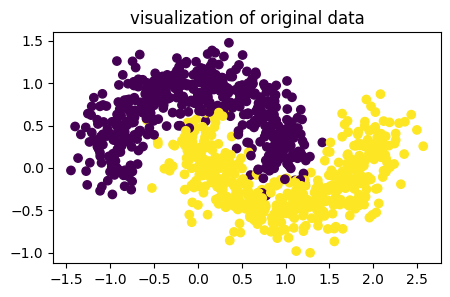

In [48]:
N_SAMPLES=1000
RANDOM_STATE=42
EPOCHS=1000
SAMPLING=100
X, y=make_moons(N_SAMPLES, noise=0.2,random_state=RANDOM_STATE)

plt.figure(figsize=[5,3])
plt.scatter(X[:,0],X[:,1],c=y)
plt.title('visualization of original data')

X_tensor=torch.from_numpy(X).type(torch.float32).to('mps')
y_tensor=torch.from_numpy(y).type(torch.float32).to('mps')

X_train, X_test, y_train, y_test=train_test_split(X_tensor, y_tensor, test_size=.2)

epoch: 100: train loss: 0.44, test loss: 0.43, accuracy: 82.00%
epoch: 200: train loss: 0.30, test loss: 0.28, accuracy: 85.50%
epoch: 300: train loss: 0.25, test loss: 0.22, accuracy: 88.50%
epoch: 400: train loss: 0.21, test loss: 0.18, accuracy: 93.00%
epoch: 500: train loss: 0.16, test loss: 0.13, accuracy: 95.50%
epoch: 600: train loss: 0.12, test loss: 0.10, accuracy: 98.00%
epoch: 700: train loss: 0.10, test loss: 0.08, accuracy: 98.50%
epoch: 800: train loss: 0.09, test loss: 0.06, accuracy: 98.00%
epoch: 900: train loss: 0.08, test loss: 0.06, accuracy: 98.00%
epoch: 1000: train loss: 0.07, test loss: 0.05, accuracy: 98.00%


Text(0.5, 1.0, 'Plot of Accuracies (%)')

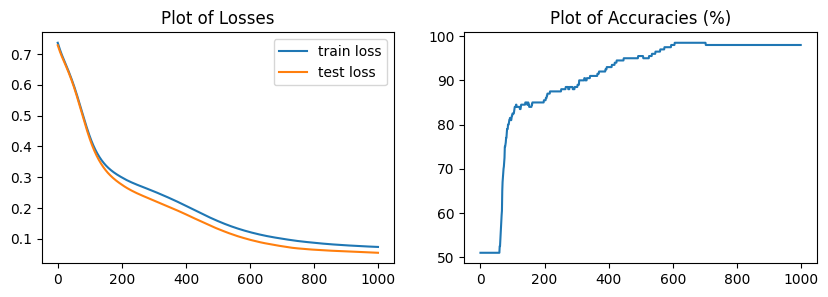

In [49]:
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)

CircularModel=nn.Sequential(
    nn.Linear(X_tensor.shape[1],16),
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU(),
    nn.Linear(32,1),
).to('mps')

model=CircularModel
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
train_losses,test_losses,accuracies=[],[],[]

for epoch in range(EPOCHS):
    model.train()
    y_train_pred=model(X_train)
    train_loss=loss_fn(y_train_pred.squeeze(-1),y_train)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.to('cpu').item())

    model.eval()
    with torch.inference_mode():
        y_test_pred=model(X_test)
        test_loss=loss_fn(y_test_pred.squeeze(-1),y_test)
        test_losses.append(test_loss.to('cpu').item())
        acc=np.mean(np.where(y_test_pred.squeeze(-1).to('cpu').numpy()>0.5,1,0)==y_test.to('cpu').numpy())
        accuracies.append(acc*100)

    if (epoch+1) % SAMPLING == 0:
        print(f"epoch: {epoch+1}: train loss: {train_loss:.2f}, test loss: {test_loss:.2f}, accuracy: {acc*100:.2f}%")

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train loss', 'test loss'])
plt.title('Plot of Losses')
plt.subplot(122)
plt.plot(accuracies)
plt.title('Plot of Accuracies (%)')

In [50]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

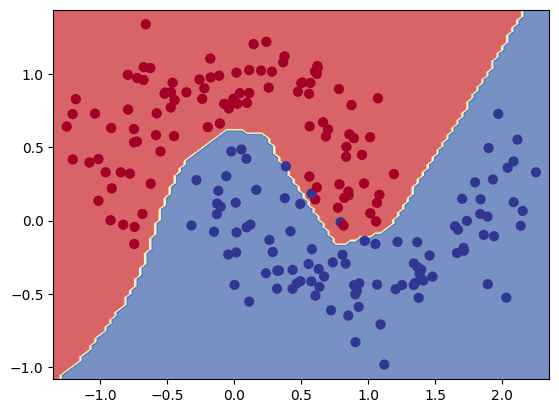

In [51]:
model.eval()
with torch.inference_mode():
    y_test_pred=model(X_test)
    y_test_pred=np.where(y_test_pred.squeeze(-1).to('cpu').numpy()>0.5,1,0)

plt.scatter(X_test[:,0].to('cpu').numpy(),X_test[:,1].to('cpu').numpy(),c=y_test_pred)
plot_decision_boundary(model, X_test, y_test)